In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, and_, null

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement=Base.classes.measurement
Station=Base.classes.station

# Create our session (link) from Python to the DB
session=Session(engine)

In [8]:
# Find the columns info for 'measurement' table
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
# Find the columns info for 'station' table
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [10]:
# preview data example from 'measurement' table, using sqlalchemy core
engine.execute("select * from measurement limit 3").fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0)]

In [11]:
# preview data example from 'station' table, using sqlalchemy core
engine.execute("select * from station limit 3").fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)]

In [12]:
# Find the most recent date in the data set, usign sqlalchemy orm
most_recent_date_tuple=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date_tuple

('2017-08-23',)

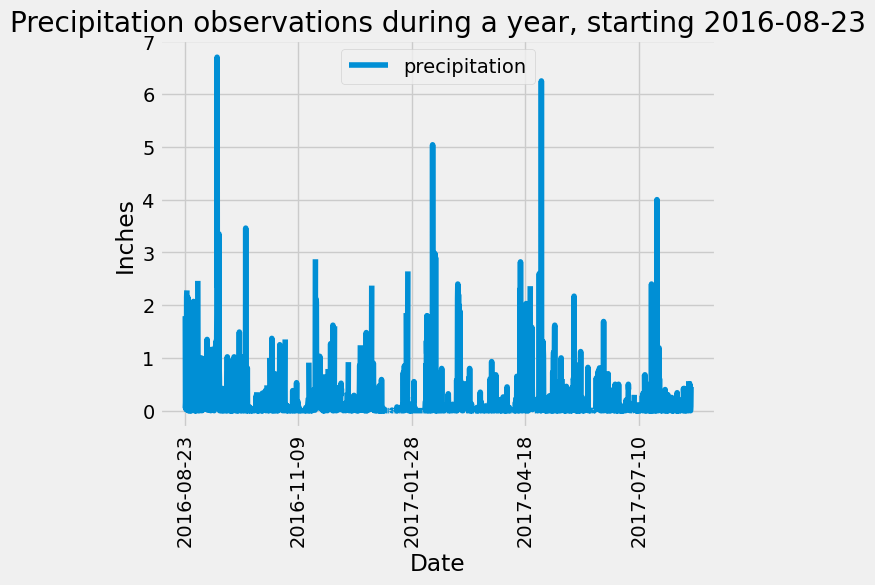

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date_string=most_recent_date_tuple[0]
starting_point = dt.datetime.strptime(most_recent_date_string,'%Y-%m-%d') # output: datetime.datetime(2017, 8, 23, 0, 0)

# Calculate the date one year from the last date in data set.
end_point=starting_point-dt.timedelta(days=365) # output: datetime.datetime(2016, 8, 23, 0, 0)
end_point_string=dt.datetime.strftime(end_point,'%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
perc_scores_list_of_tuples=session.query(Measurement.date,Measurement.prcp).filter(Measurement.date>=end_point_string).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
perc_scores_df=pd.DataFrame(perc_scores_list_of_tuples,columns=["date","precipitation"])
perc_scores_df.set_index("date", inplace=True)


# Sort the dataframe by date
perc_scores_df=perc_scores_df.sort_values(by="date")

# Use Pandas Plotting with Matplotlib to plot the data
perc_scores_df.plot(rot=90)
plt.title(f"Precipitation observations during a year, starting {end_point_string}")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.show()

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
perc_scores_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(Station.station.distinct())).scalar()

9

In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
stations_records_count=session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
stations_records_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station=stations_records_count[0][0]
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter_by(station=most_active_station).all()

[(54.0, 85.0, 71.66378066378067)]

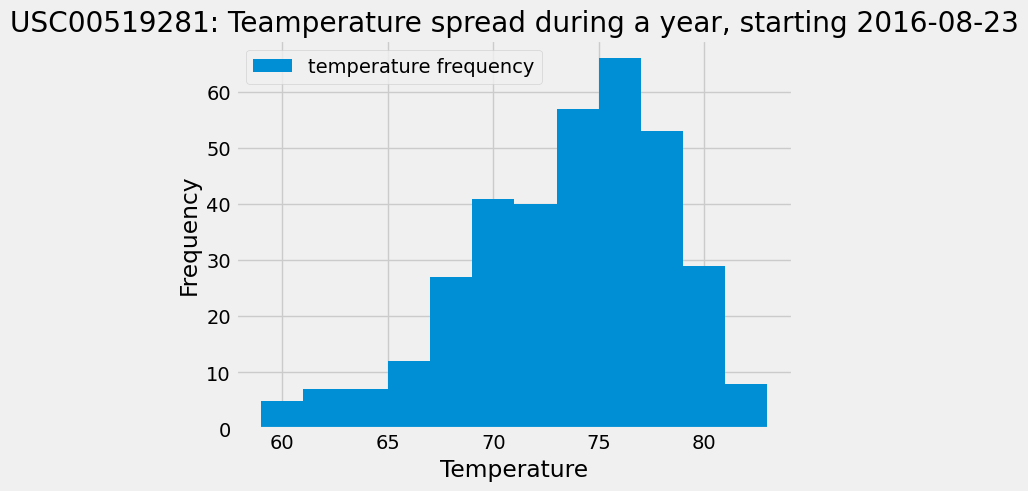

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperatures_list_of_tuples=session.query(Measurement.date,Measurement.tobs).filter(and_(Measurement.date>=end_point_string,Measurement.station==most_active_station)).all()
# Save the query results as a Pandas DataFrame. Explicitly set the column names
temperature_df=pd.DataFrame(temperatures_list_of_tuples,columns=["date","temperature"])
temperature_df.set_index("date", inplace=True)

# Sort the dataframe by date
temperature_df=temperature_df.sort_values(by="date")

# plot the results as a histogram
temperature_df.temperature.plot.hist(bins=12,label="temperature frequency")
plt.title(f"{most_active_station}: Teamperature spread during a year, starting {end_point_string}")
plt.xlabel("Temperature")
plt.legend(loc="best")
plt.show()

# Close Session

In [19]:
# Close Session
session.close()